<IPython.core.display.Javascript object>


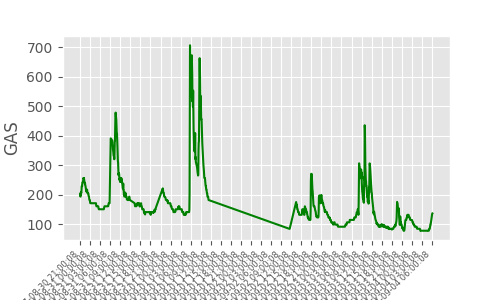

<IPython.core.display.Javascript object>


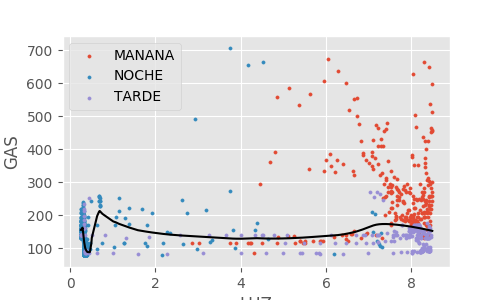

<IPython.core.display.Javascript object>


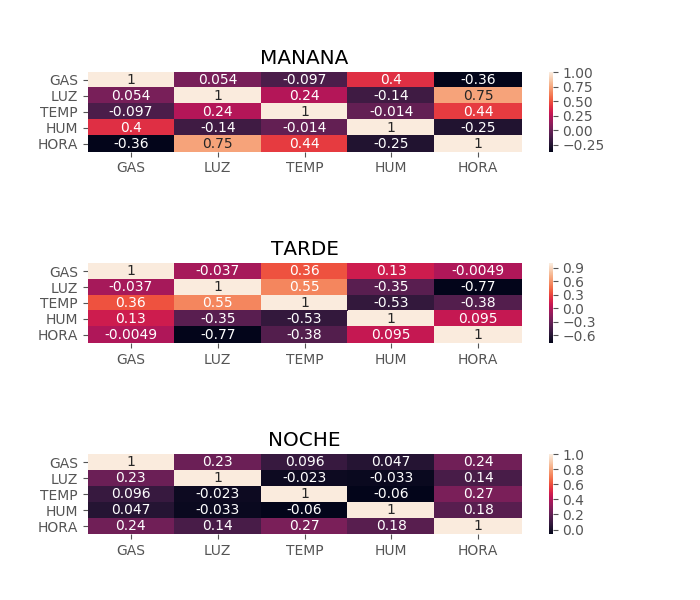

In [22]:

##################################################################################################

##			 TELEMETRIA PROYECTO. PREPARACION DE DATOS / HERRAMIENTA DE VISUALIZACION

##################################################################################################


## Section 0. Import packages

%matplotlib notebook
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib import style
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns


## Section 1. Import raw data and preprocessing

names_data=["ID","FECHA","GRUPO","GAS","LUZ","TEMP","HUM"]
time_freq_ww='4min'

df = pd.read_csv('TM1.csv', delimiter=',', names=names_data)
df['FECHA'] =  pd.to_datetime(df['FECHA'], format='%Y-%m-%d %H:%M:%S')
start = df['FECHA'].min()
end = df['FECHA'].max()

datelist = pd.date_range(start=start, end=end,freq=time_freq_ww)

array = datelist<=df['FECHA'][100]

interval_list = []

for date in df['FECHA']:
    array = datelist<=date
    interval_list.append(datelist[array.sum()-1])
   

df['FECHA_INTERVALO'] = pd.Series(interval_list, dtype='category')
df.head()

grouped = df.groupby(df['FECHA_INTERVALO'],as_index=False)

TM = grouped.mean().drop('ID',axis=1)
TM['HORA'] = pd.Series([x.hour for x in TM['FECHA_INTERVALO']])

TM['FECHA']=pd.to_datetime(TM['FECHA_INTERVALO'])

jornada_list=[]
for date in TM['HORA']:
    if date>12 and date<=18:
        array="TARDE"
    else:
        if date>=6 and date<=12:
            array="MANANA"
        else:
            array="NOCHE"
    jornada_list.append(array)
    
TM['JORNADA']=pd.Series(jornada_list)

## Section 2. Data Visualization

## Section 2.1 State of the data

style.use('ggplot')

x_var = 'FECHA'
y_var = 'GAS'
start_plot=TM['FECHA'].min()
end_plot=TM['FECHA'].max()
time_freq_ww_plot='180min'


f = plt.figure(figsize=(5,3), dpi=100)
a = f.add_subplot(111)
a.plot_date(TM[x_var],TM[y_var],'g')
a.set_xlabel(x_var)
a.set_ylabel(y_var)
a.xaxis.set_ticks(pd.date_range(start=start_plot, end=end_plot, freq=time_freq_ww_plot))
a.xaxis.set_ticklabels(pd.date_range(start=start_plot, end=end_plot, freq=time_freq_ww_plot))
a.xaxis.set_tick_params(labelsize=6)
f.autofmt_xdate(rotation=45) 

## Section 2.2 Relation between variables

x_var = 'LUZ'
y_var = 'GAS'
frac_points=0.4

group_jornada = TM.groupby("JORNADA")
f = plt.figure(figsize=(5,3), dpi=100)
a= f.add_subplot(111)
lowess = sm.nonparametric.lowess
for name,group in group_jornada:
        a.scatter(group_jornada.get_group(name)[x_var], group_jornada.get_group(name)[y_var], label=name, s=5)
        #z=lowess(group_jornada.get_group(name)[y_var],group_jornada.get_group(name)[x_var])
        #a.plot(z[0:,0],z[0:,1])

z=lowess(TM[y_var],TM[x_var], frac=frac_points)
a.plot(z[0:,0],z[0:,1],c="black")
a.legend()
a.set_xlabel(x_var)
a.set_ylabel(y_var)

## Section 2.3 Correlation heatmap 


group_jornada = TM.drop(["FECHA_INTERVALO", "GRUPO", "FECHA"],axis=1).groupby("JORNADA")

f = plt.figure(figsize=(7,6), dpi=100)
a=plt.subplot2grid((5,1), (0,0), rowspan=1, colspan=1)
sns.heatmap(group_jornada.get_group('MANANA').corr(), annot=True)
plt.title("MANANA")
b=plt.subplot2grid((5,1), (2,0), rowspan=1, colspan=1)
sns.heatmap(group_jornada.get_group('TARDE').corr(), annot=True)
plt.title("TARDE")
c=plt.subplot2grid((5,1), (4,0), rowspan=1, colspan=1)
sns.heatmap(group_jornada.get_group('NOCHE').corr(), annot=True)
plt.title("NOCHE")
